# Baseline Model: XGBoost
In this notebook, we forecast the fastest Bitcoin transaction fee (sats/vByte) using XGBoost Regressor. 

### Why We Chose XGBoost as a Baseline Model
We selected XGBoost as one of our baseline models because it provides a strong balance between performance, interpretability, and efficiency when working with structured tabular data. Unlike traditional linear models, XGBoost can effectively capture non-linear relationships and complex interactions between features, which includes both temporal patterns (via lag features) and contextual signals (like mempool and market conditions). 

Our target variable recommended_fee_fastestFee is not only time-dependent but also correlates with other recommended fee rates (e.g., halfHourFee, hourFee, etc.), which serve as important external features. When there are known correlations between the target and input features in the presence of redundancy or nonlinearity, XGBoost offers both high performance and interpretability. The exploratory data analysis confirms these relationships and reveals substantial variability and temporal structure in the data, which makes simpler linear models less effective. XGBoost, in contrast, is robust to multicollinearity, handles missing data gracefully, and naturally incorporates lag features. Additionally, it provides useful feature importance insights and performs well with minimal preprocessing, which makes it a practical and reliable starting point for benchmarking more complex forecasting models.

By tuning key hyperparameters and evaluating the model with MAE and RMSE, we can gauge how well tree-based methods handle fee rate prediction and set a meaningful performance benchmark.


### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib  
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import seaborn as sns

### Load data
To ensure that we only train on complete data, we drop the lag rows which contain NaN values introduced by lag feature creation. 

In [2]:
df = pd.read_parquet('../data/processed/preprocessed_xgboost.parquet')
df.dropna(inplace = True)

# Remove recent lag features (lag_1 to lag_10) to reduce data leakage
# lag_columns = [col for col in df.columns if 'lag_' in col and int(col.split('_')[-1]) <= 10]
# df = df.drop(columns=lag_columns)

df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,recommended_fee_fastestFee_lag_567,recommended_fee_fastestFee_lag_568,recommended_fee_fastestFee_lag_569,recommended_fee_fastestFee_lag_570,recommended_fee_fastestFee_lag_571,recommended_fee_fastestFee_lag_572,recommended_fee_fastestFee_lag_573,recommended_fee_fastestFee_lag_574,recommended_fee_fastestFee_lag_575,recommended_fee_fastestFee_lag_576
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-07 02:10:00,1599085.0,997970.50,3163.0,2605581.0,2.318812,3.0,3.0,3.0,2.0,1.0,...,2.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0,2.0
2025-03-07 02:15:00,1669877.0,997939.25,3694.0,3401718.0,3.000000,3.0,3.0,3.0,2.0,1.0,...,3.0,2.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0
2025-03-07 02:20:00,1653798.0,997925.25,3953.0,3979317.0,3.007259,4.0,3.0,3.0,2.0,1.0,...,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,4.0,3.0
2025-03-07 02:25:00,1323266.0,997994.75,1600.0,2293299.0,1.984234,2.0,2.0,2.0,2.0,1.0,...,4.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,4.0
2025-03-07 02:30:00,1485187.0,997943.50,2471.0,2943294.0,2.047671,3.0,3.0,3.0,2.0,1.0,...,4.0,4.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0


### Define features and target
We chose recommended_fee_fastestFee as target, and external features and lag features as input. 

In [3]:
y = df["recommended_fee_fastestFee"]
X = df.drop(columns = "recommended_fee_fastestFee")

### Data split
We chose the last 24-hour data as test data. 

In [4]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# last 24h as test
split_index = int(len(X) - 24*(60/5))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Verify time separation
print('Train time range:', X_train.index.min(), 'to', X_train.index.max())
print('Test time range:', X_test.index.min(), 'to', X_test.index.max())

Train time range: 2025-03-07 02:10:00 to 2025-04-14 09:50:00
Test time range: 2025-04-14 09:55:00 to 2025-04-15 09:50:00


### XGBoost model

In [5]:
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1
)

### Params
We choose RandomizedSearch to optimize the model. It allows us to explore a broader space efficiently with fewer iterations. Here are the ranges of parameters.

n_estimators: [50, 100, 150] 
It controls the number of boosting rounds. Small values (50) may underfit, while higher values (150) may lead to better performance but risk overfitting. Keeping this modest helps reduce training time and keeps the search space focused.

max_depth: [1, 2, 3] 
It controls the maximum depth of individual trees. Shallow trees (1–3) are less likely to overfit and are more interpretable. Especially appropriate when the number of features is high and the time resolution is short (5-min data), helping avoid overly complex trees.

learning_rate: [0.01, 0.05, 0.1] 
Learning rate shrinks the contribution of each tree. Lower values slow down learning but improve generalization. Chosen to strike a balance between convergence speed and model stability.

subsample: [0.6, 0.8, 0.9] 
Fraction of rows used per tree. It introduces randomness ,helping prevent overfitting and improving robustness. 0.6–0.9 allows experimentation with more regularized models.

colsample_bytree: [0.6, 0.8, 0.9] 
Fraction of columns (features) used to build each tree. Especially helpful when there are many features. It helps prevent overfitting by decorrelating trees.

gamma: [1, 3, 5] 
Minimum loss reduction to make a split. It acts as a regularizer to control tree growth. Higher values force the model to make only meaningful splits.

reg_lambda: [5, 10, 20] 
L2 regularization on leaf weights. It prevents overly large weights, stabilizing the model especially with correlated features. It also helps handle multicollinearity and improve generalization.

reg_alpha: [5, 10, 20] 
L1 regularization (sparsity). It encourages feature selection by zeroing out less useful ones, and is particularly useful in high-dimensional datasets (e.g., many lag features).

In [6]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 0.9],
    'gamma': [1, 3, 5],
    'reg_lambda': [5, 10, 20],
    'reg_alpha': [5, 10, 20]
}
# TimeSeries CV
tscv = TimeSeriesSplit(n_splits=5)


We evaluate the forecast using MAE, RMSE and MAPE. 

In [7]:
# Define MAPE scorer
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-10  # to avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon)))
    
# mae + rmse + mape
scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': make_scorer(
        lambda y, y_pred: -np.sqrt(mean_squared_error(y, y_pred))
    ),
    'mape': make_scorer(lambda y, y_pred: -mean_absolute_percentage_error(y, y_pred))
}


### Random search
We performs hyperparameter tuning for an XGBoost model using RandomizedSearchCV, a more efficient alternative to exhaustive grid search. After tuning, the model will be retrained on the full training set using the hyperparameters that gives the lowest Mean Absolute Error (MAE).

In [8]:
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='mae',
    cv=tscv,
    verbose=1,
    return_train_score=True
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [1, 2, 3],
                                        'n_estimators': [50, 100, 150],
                                        'reg_alpha': [5, 10, 20],
                                        'reg_lambda': [5, 10, 20],
                                        'subsample': [0.6, 0.8, 0.9]},
                   refit='mae', return_train_score=True,
                   scoring={'mae': 'neg_mean_absolute_error',
                            'mape': make_scorer(<lambda>, response_method='predict'),
                            'rmse': make_scorer(<lambda>, response_method='predict')},
                   verbose=1)

### Best model
Here we get the best model with hyperparameters. 

In [9]:
best_model = random_search.best_estimator_
print("Best parameters (MAE):", random_search.best_params_)

Best parameters (MAE): {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 3, 'colsample_bytree': 0.9}


### Prediction
We use the best model to make prediction on test data and get the result. 

In [10]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")

MAE: 0.1374
RMSE: 0.2289
MAPE: 0.0659


### Prediction vs Actual data

We draw the predicted values and actual ones in the same plot to assess the performance. 

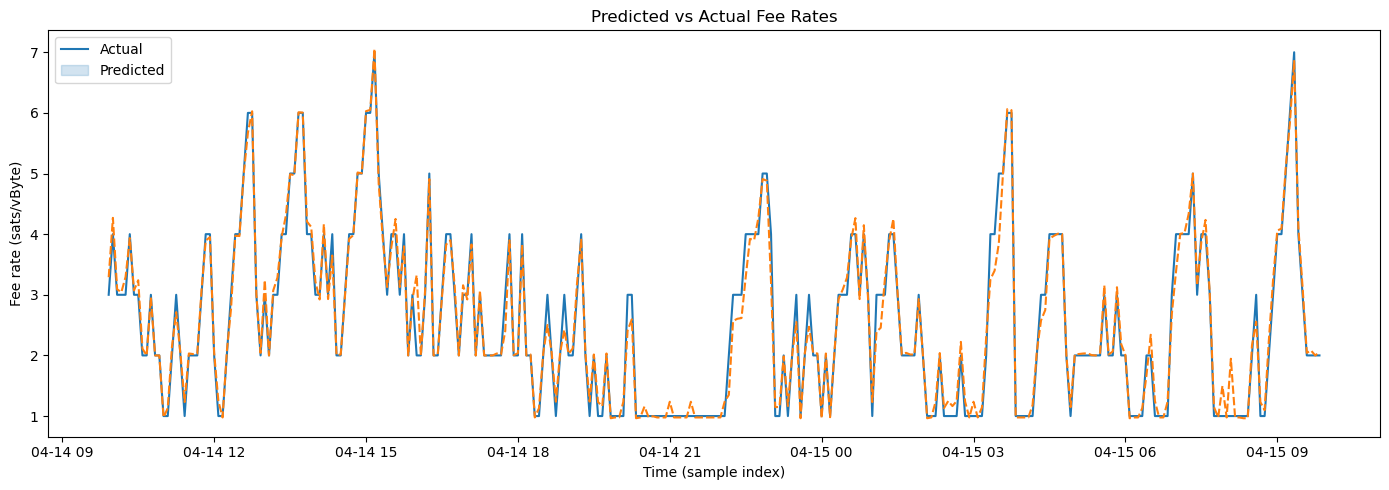

In [11]:
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}, index=y_test.index)

plt.figure(figsize=(14, 5))
sns.lineplot(data=result_df)
plt.title('Predicted vs Actual Fee Rates')
plt.xlabel('Time (sample index)')
plt.ylabel('Fee rate (sats/vByte)')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()
plt.show()